# Understanding feature interactions with SHAP : sklearn's RandomForestRegressor with OHE inputs

In [1]:
import pandas
import sklearn
import scipy
from sklearn import model_selection, linear_model, preprocessing, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import cluster
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rxns_df_x = pandas.read_csv("godineau2023_reactions_OHE.csv")
rxns_x = rxns_df_x.to_numpy().copy()
rxns_x = np.delete(rxns_x, 0, 1)
rxns_df_x = rxns_df_x.drop("Unnamed: 0", axis=1)
rxns_df_y = pandas.read_csv("godineau2023_yields_OHE.csv")
rxns_y = rxns_df_y.to_numpy().copy()
rxns_y = np.delete(rxns_y, 0, axis=1)
rxns_df_y = rxns_df_y[["Yield of 3aa"]]

In [3]:
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [4]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

C:\Users\Public.utilisateur\AppData\Local\Temp\ipykernel_15284\1165176309.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [5]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.658265719865249
Validation RMSE:11.951637218117858
Validation MAE:8.587779999999999
Test Set Accuracy with r2 : 0.6763216865290409
Test RMSE:12.25361065779185
Test MAE:9.438047500000001


Slightly more accurate than the non-OHE version. The validation set is less accurate than the 80/20 model while the test set is more accurate.

In [6]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_val, check_additivity=False)

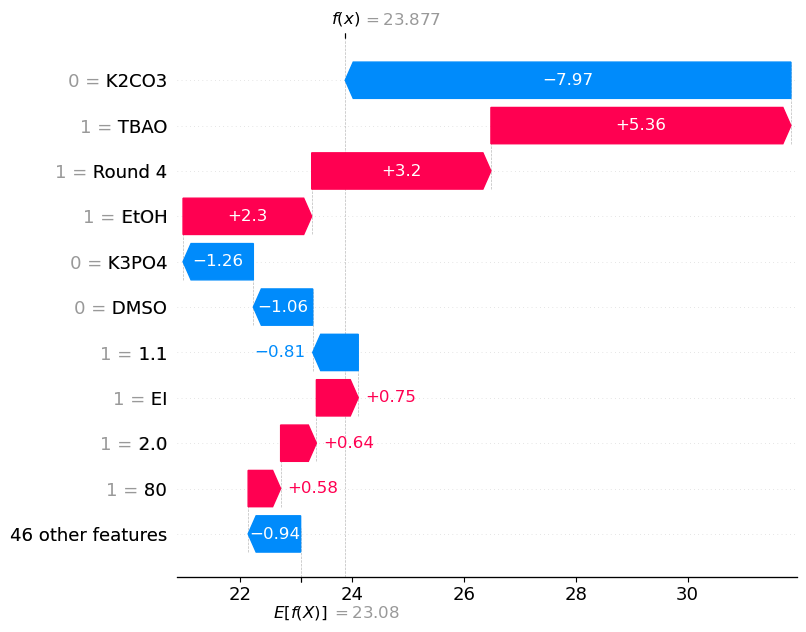

In [8]:
shap.plots.waterfall(shap_values[0], max_display=11)

Every observation here makes sense in respect to the results.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


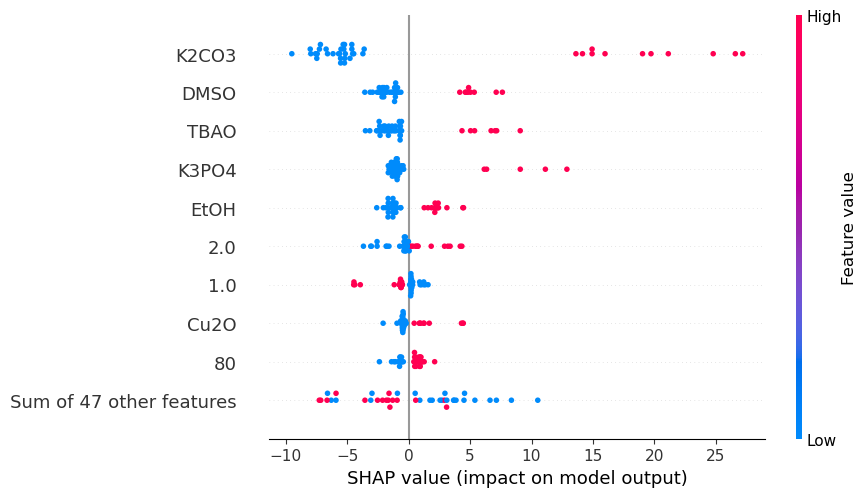

In [9]:
shap.plots.beeswarm(shap_values)

All the top features except the 1.0 base equivalent are those that make the yield higher when they are present (value = 1). Their positive effect is confirmed in data_exploration.ipynb

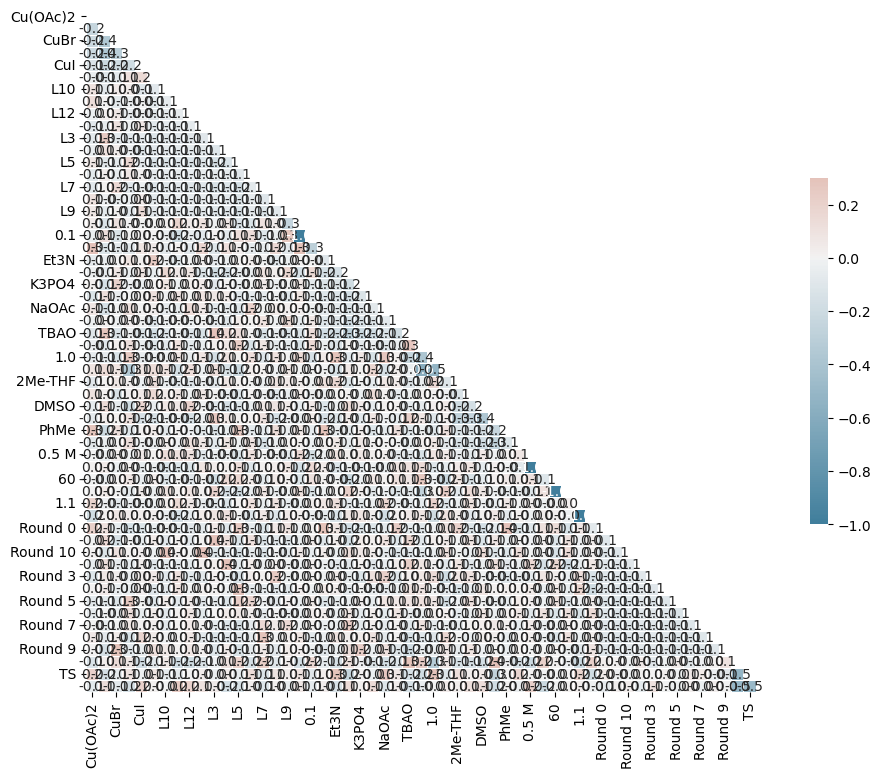

In [9]:
# Compute the correlation matrix
corr = x_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5},
annot=True, fmt=".1f")
plt.show()

That is a lot of interactions. Somewhat expected from a chemical system, though we should use another visualisation method for them to be clearer.

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


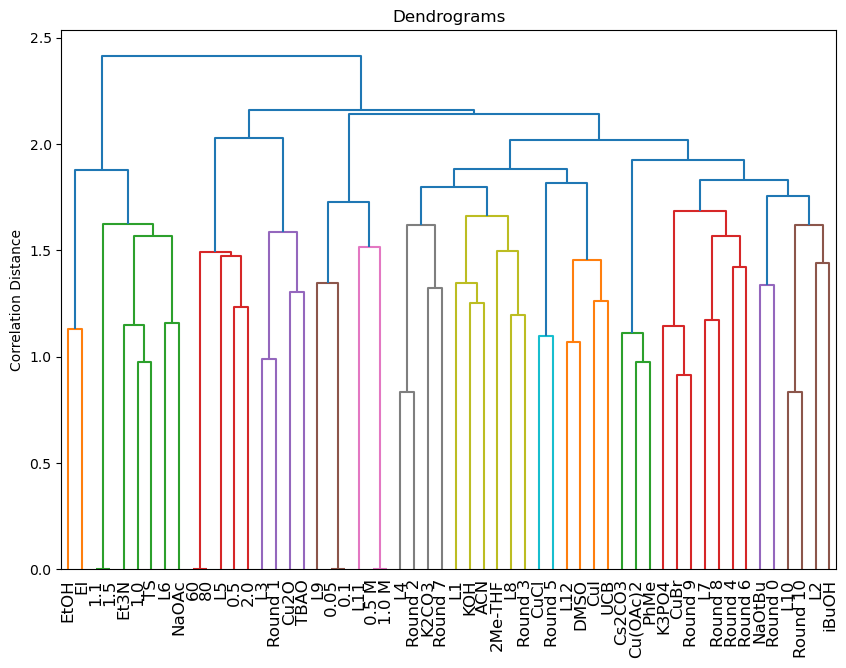

In [10]:
correlation_matrix = x_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix
import scipy.cluster.hierarchy as sch
clustering = sch.linkage(dist_matrix, method="complete")
#clustering = shap.utils.hclust(X_train, metric='correlation')
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = hierarchy.dendrogram(clustering, labels=x_train.columns)
# Rotate labels for better readability
plt.xticks(rotation=90)
# Increase label size for better visibility
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()

Nice feature interactions:
- the temperatures (60 and 80) are in the same cluster
- BnNH2 equivalents 1.1, 1.5 are in the same cluster
- Rounds 8, 4, and 6 are in the same cluster
- Molarities 0.5 and 1 are in the same cluster
- Ligand equivalents 0.1 and 0.05 are in the same cluster
##### Other than that:
- Rounds, Acquisition types, Solvents, Bases, Ligands, Cu sources are scattered throughout. Some are closer to each other (example: rounds 9, 8, 6 and 4 in the same cluster).

The use of OHE has made the recognition of interactions easier, especially when it comes to temperature (if 60 -> 0, then 80 -> 1 and vice versa), which is why this model is more efficient than its non-OHE counterpart.

In [11]:
masker = shap.maskers.Partition(x_train, clustering=clustering)
explainer2 = shap.PartitionExplainer(model.predict, masker)
shap_values2 = explainer2(x_val)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:   8%|▊         | 3/40 [00:16<01:52,  3.04s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X d

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  15%|█▌        | 6/40 [00:29<02:17,  4.05s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X d

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  25%|██▌       | 10/40 [00:46<02:15,  4.51s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  35%|███▌      | 14/40 [01:03<02:00,  4.62s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  45%|████▌     | 18/40 [01:20<01:43,  4.70s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  52%|█████▎    | 21/40 [01:33<01:28,  4.63s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  68%|██████▊   | 27/40 [01:53<00:49,  3.84s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  75%|███████▌  | 30/40 [02:07<00:44,  4.50s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer:  92%|█████████▎| 37/40 [02:36<00:13,  4.36s/it]X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X 

  0%|          | 0/498 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
Partition explainer: 41it [02:53,  4.34s/it]                        


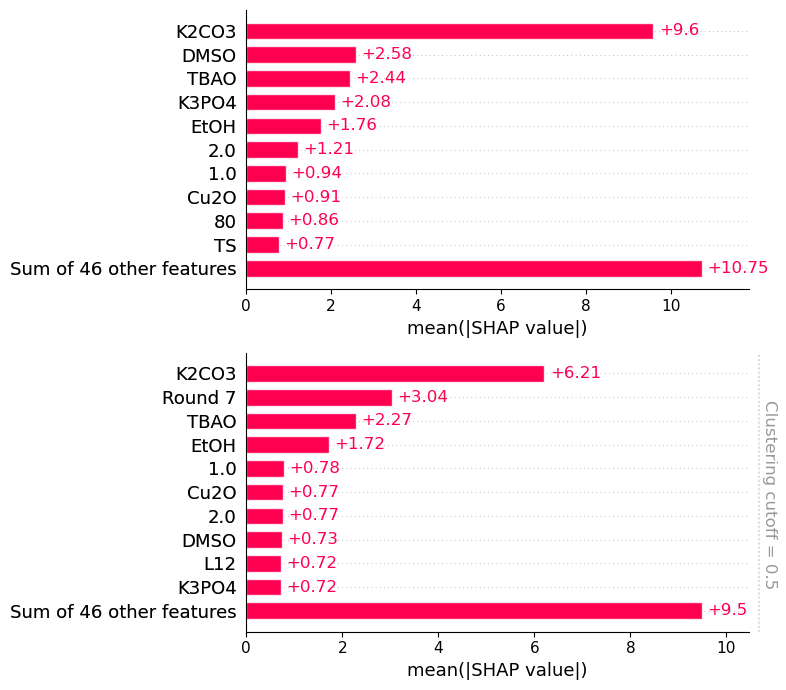

In [15]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(
shap_values2, max_display=11, show=False, clustering_cutoff=0.5
)
plt.tight_layout()
plt.show()

The correlations are very significant here.

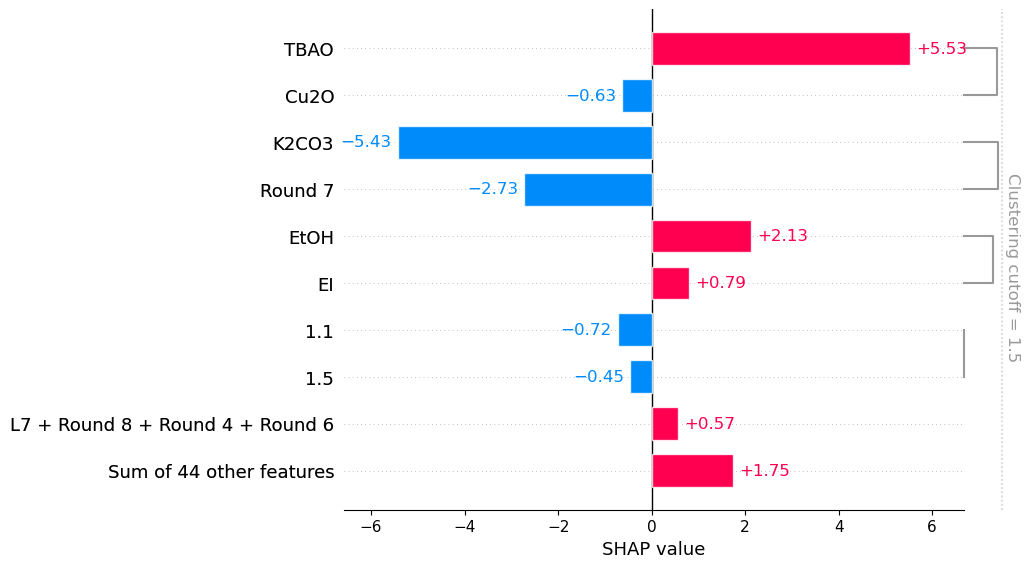

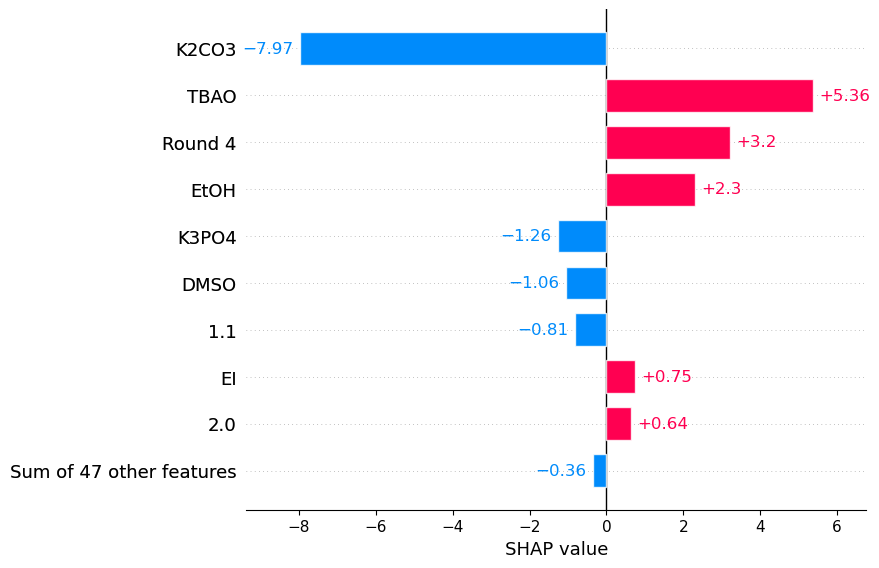

In [14]:
shap.plots.bar(shap_values2[0], clustering_cutoff=1.5)
shap.plots.bar(shap_values[0])

Some of the rounds getting clustered together is pretty nice.

## Combining OHE columns

In [16]:
def combine_one_hot(shap_values, name, mask, return_original=True):
    """  shap_values: an Explanation object
          name: name of new feature
          mask: bool array same lenght as features

         This function assumes that shap_values[:, mask] make up a one-hot-encoded feature
    """
    mask = np.array(mask)
    mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]

    sv_name = shap.Explanation(shap_values.values[:, mask],
                               feature_names=list(mask_col_names),
                               data=shap_values.data[:, mask],
                               base_values=shap_values.base_values,
                               display_data=shap_values.display_data,
                               instance_names=shap_values.instance_names,
                               output_names=shap_values.output_names,
                               output_indexes=shap_values.output_indexes,
                               lower_bounds=shap_values.lower_bounds,
                               upper_bounds=shap_values.upper_bounds,
                               main_effects=shap_values.main_effects,
                               hierarchical_values=shap_values.hierarchical_values,
                               clustering=shap_values.clustering,
                               )

    new_data = (sv_name.data * np.arange(sum(mask))).sum(axis=1).astype(int)

    svdata = np.concatenate([
        shap_values.data[:, ~mask],
        new_data.reshape(-1, 1)
    ], axis=1)

    if shap_values.display_data is None:
        svdd = shap_values.data[:, ~mask]
    else:
        svdd = shap_values.display_data[:, ~mask]

    svdisplay_data = np.concatenate([
        svdd,
        mask_col_names[new_data].reshape(-1, 1)
    ], axis=1)

    new_values = sv_name.values.sum(axis=1)
    svvalues = np.concatenate([
        shap_values.values[:, ~mask],
        new_values.reshape(-1, 1)
    ], axis=1)
    svfeature_names = list(np.array(shap_values.feature_names)[~mask]) + [name]

    sv = shap.Explanation(svvalues,
                          base_values=shap_values.base_values,
                          data=svdata,
                          display_data=svdisplay_data,
                          instance_names=shap_values.instance_names,
                          feature_names=svfeature_names,
                          output_names=shap_values.output_names,
                          output_indexes=shap_values.output_indexes,
                          lower_bounds=shap_values.lower_bounds,
                          upper_bounds=shap_values.upper_bounds,
                          main_effects=shap_values.main_effects,
                          hierarchical_values=shap_values.hierarchical_values,
                          clustering=shap_values.clustering,
                          )
    if return_original:
        return sv, sv_name
    else:
        return sv

In [35]:
rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv",sep='\t' )
def bool_feature(name):
    bool_list=[]
    for n in rxns_df_x.columns:
        if str(n) in list(set(rxns_df_x.columns.to_list()).intersection(set(rxns_df[f'{name}'].to_list()))):
            bool_list.append(True)
        else:
            bool_list.append(False)
    return np.array(bool_list)

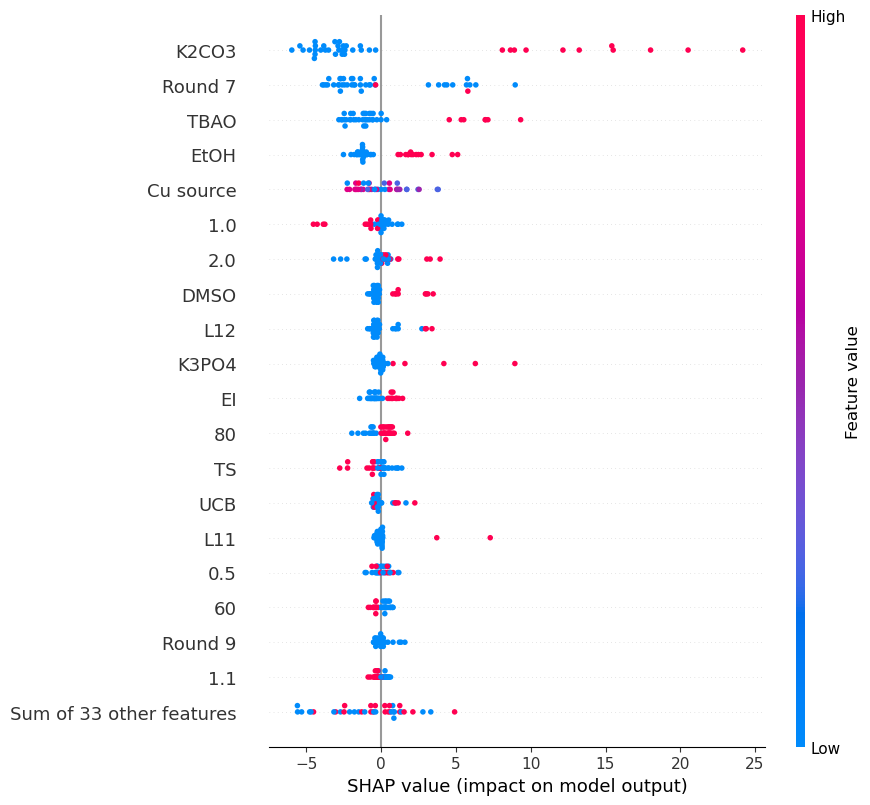

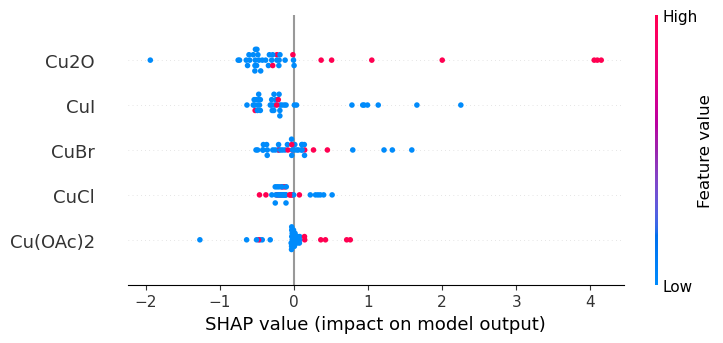

In [47]:
shap_values3,sv_occ = combine_one_hot(shap_values2, "Cu source", bool_feature('Cu source'))
shap.plots.beeswarm(shap_values3, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Surprising to see CuBr (the Cu source leading to the highest yield) not only having a weak SHAP value but also having a positive SHAP value on the model output when it is not present. Consider that this might come from it not being used as many times as Cu2O which is the Cu source found the most times in the data set, and because it leads to lower yields than CuI when it is not present.

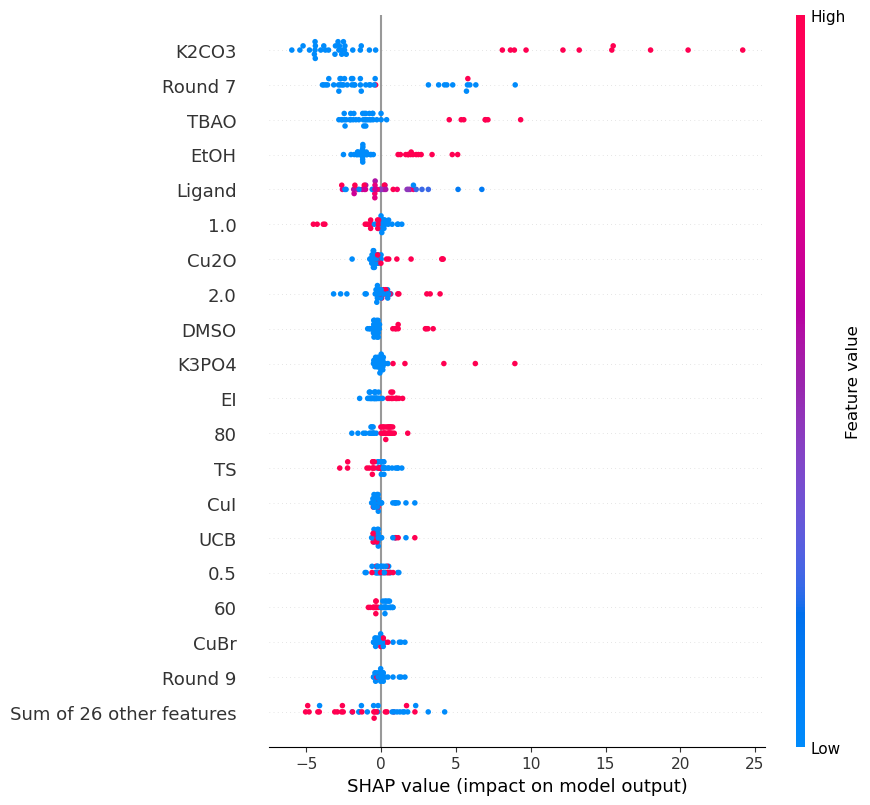

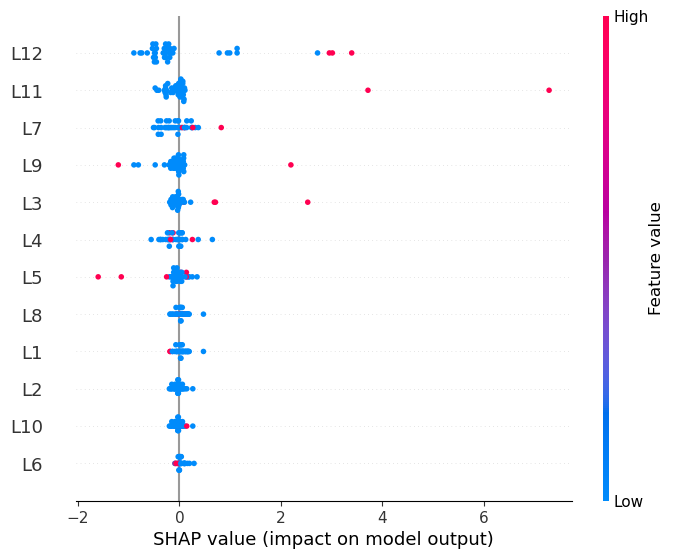

In [48]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Ligand", bool_feature('Ligand'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

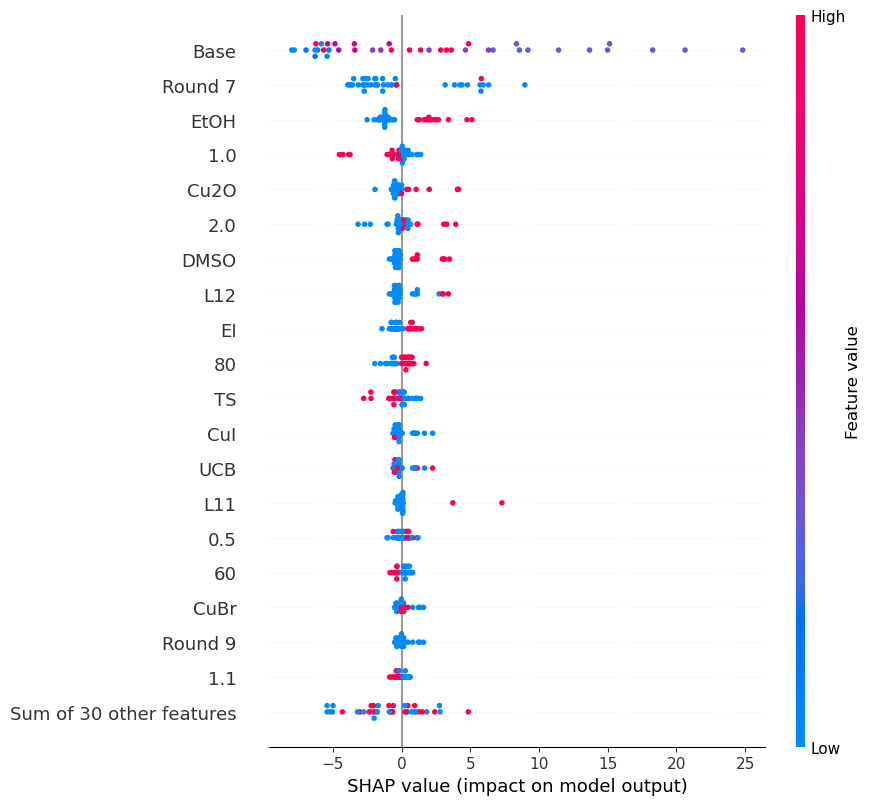

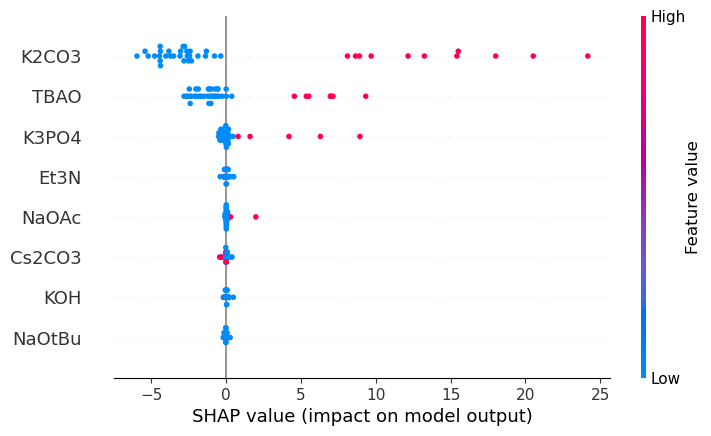

In [49]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Base", bool_feature('Base'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

No surprises here, since K2CO3 is used more times than K3PO4, it having more SHAP values with bigger impacts makes sense despite K3PO4 leading to the highest yield overall. The only bases that seem to have a significantly negative impact the yield are Et3N and KOH, which is confirmed in data_exploration.ipynb

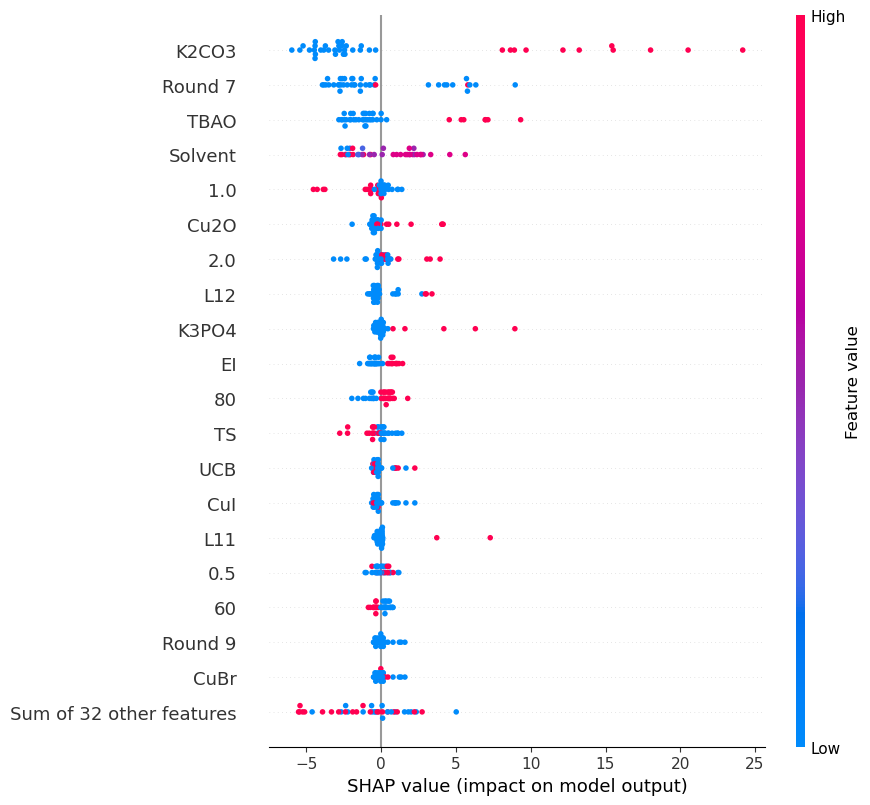

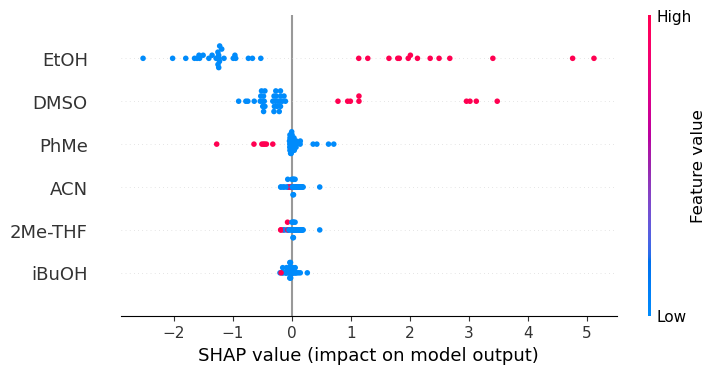

In [50]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Solvent", bool_feature('Solvent'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Same explanation here as to why EtOH has more SHAP values with higher impacts than DMSO despite DMSO being the solvent that lead to the highest yield. Notice PhMe is an especially inefficient solvent.

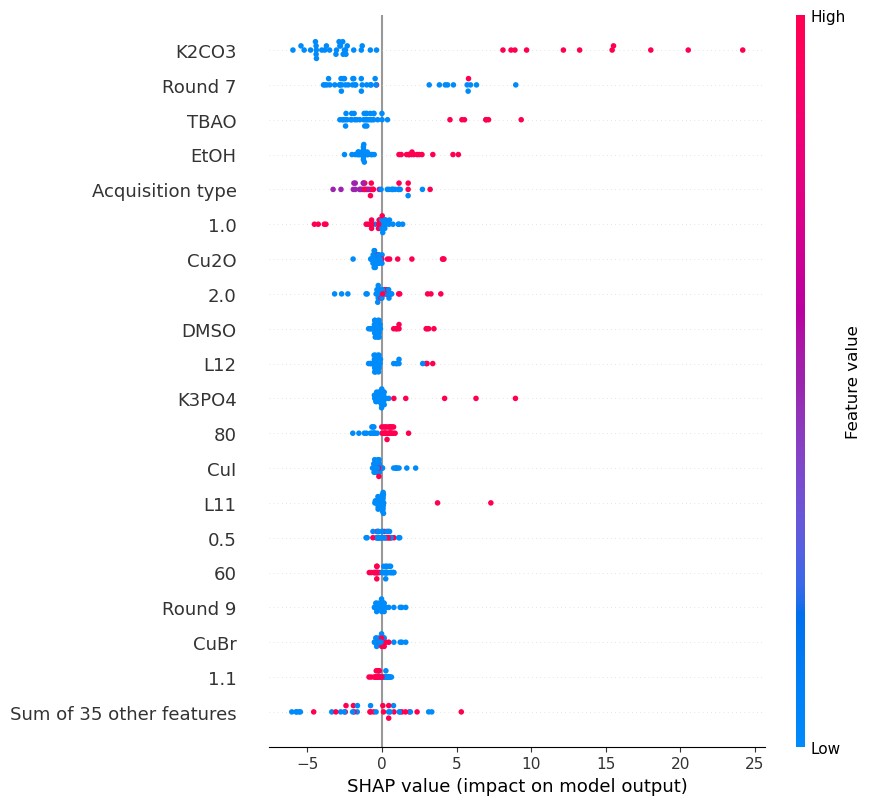

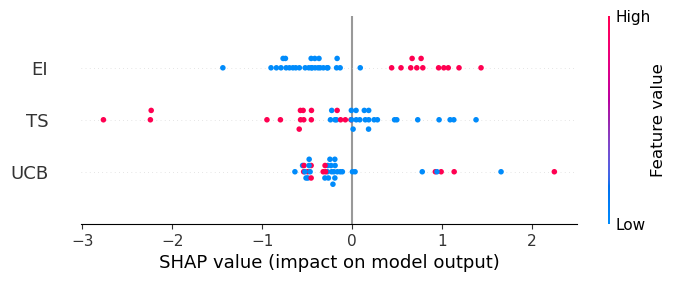

In [61]:
shap_values,sv_occ = combine_one_hot(shap_values2, "Acquisition type", bool_feature('Acquisition type'))
shap.plots.beeswarm(shap_values, max_display=20)
shap.plots.beeswarm(sv_occ, max_display=20)

Expected improvement seems to overall be the best acquisition method for this experiment.

Text(0.5, 0, 'Actual')

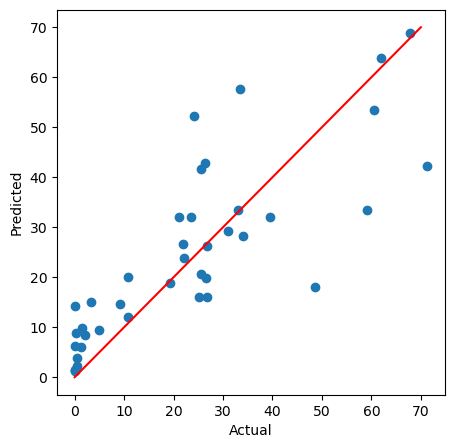

In [63]:
plt.figure(figsize=(5,5))
plt.scatter(y_val, y_val_pred)
plt.plot([0,70], [0,70], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

Text(0.5, 0, 'Actual')

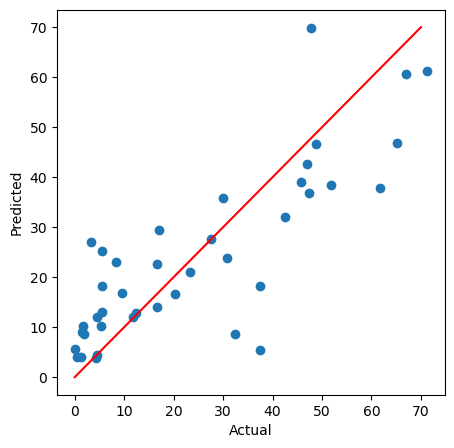

In [65]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred)
plt.plot([0,70], [0,70], color='r')
plt.ylabel('Predicted')
plt.xlabel('Actual')

The model is not the most accurate, but shows some relatively precise points.